In [ ]:
import os
import math
import librosa
import librosa.display
import IPython.display as ipd
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, cdist
from mpl_toolkits.mplot3d import Axes3D
import soundfile as sf
from prettytable import PrettyTable
import numpy as np
from sklearn.decomposition import PCAa
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from scipy.signal import hilbert, butter, filtfilt, medfilt, lfilter, wiener, convolve

In [ ]:
fruit_types = ['pera', 'banana', 'manzana', 'naranja']
audios = {fruit: [] for fruit in fruit_types}
root_dir = '../../dataset'

for dirname, _, filenames in os.walk(root_dir):
    fruit_type = os.path.basename(dirname)
    if fruit_type in fruit_types:
        audios[fruit_type].extend([os.path.join(dirname, filename) for filename in filenames if filename.endswith('.wav')])

In [ ]:
processed = {fruit: [] for fruit in fruit_types}

for dirname, _, filenames in os.walk(root_dir):
    path = os.path.basename(dirname)
    if path == 'processed':
        fruit_type = os.path.basename(os.path.dirname(dirname))
        if fruit_type in fruit_types:
            processed[fruit_type].extend([os.path.join(dirname, filename) for filename in filenames if filename.endswith('.wav')])

In [ ]:
FRAME_SIZE = 512 # In the documentation says it's convenient for speech.C
HOP_SIZE   = int(FRAME_SIZE/2)

In [ ]:
def load_audio(audiofile):
    test_audio, sr = librosa.load(audiofile, sr = None)
    duration = librosa.get_duration(filename=audiofile, sr=sr)
    return test_audio, sr, duration

In [ ]:
def time_vector(signal, duration):
    return np.linspace(0, duration, len(signal))

In [ ]:
def rms(signal):
    return librosa.feature.rms(y=signal, frame_length = FRAME_SIZE, hop_length = HOP_SIZE)

In [ ]:
def normalize(signal):
    peak = np.max(signal)
    signal/=peak
    return signal

In [ ]:
def low_pass_filter(signal, sr, cutoff_frequency = 5000):
    nyquist = 0.5 * sr
    cutoff = cutoff_frequency / nyquist
    b, a = butter(N=6, Wn=cutoff, btype='low', analog=False, output='ba')
    filtered = lfilter(b, a, signal)
    return filtered

In [ ]:
def envelope(signal):
    analytic_signal = hilbert(signal)
    return np.abs(analytic_signal)


In [ ]:
def smooth_envelope(signal, sr, cutoff_frequency=10.0):
    return low_pass_filter(envelope(signal), sr, cutoff_frequency)

In [ ]:
def knn(training, test, k_n):
    X = np.concatenate([v for v in training.values()], axis=0)
    y = np.concatenate([[k] * v.shape[0] for k, v in training.items()])

    #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Crear clasificador KNN
    knn_classifier = KNeighborsClassifier(n_neighbors = k_n)

    # Entrenar el clasificador
    knn_classifier.fit(X, y)

    # Predecir las etiquetas para los datos de prueba
    predicted_fruit = knn_classifier.predict(test)

    print(f'La fruta predicha para el nuevo audio es: {predicted_fruit[0]}')

In [ ]:
#2d
def plot_features2d(features):
    fig = plt.figure()
    colors = dict(zip(fruit_types,['green','yellow','red','orange']))
    

    for fruit, points in features.items():
        plt.scatter(points[:, 0], points[:, 1], c = colors[fruit], label=fruit)

    plt.xlabel('Eje X')
    plt.ylabel('Eje Y')
    plt.show()

In [ ]:
#3d
def plot_features3D(features:dict):
    fig = plt.figure()
    colors = dict(zip(fruit_types,['green','yellow','red','orange']))
    ax = fig.add_subplot(111, projection='3d')
    for fruit, points in features.items():
        ax.scatter(points[:, 0], points[:, 1], points[:, 2], c=colors[fruit], marker='o', label=fruit)
        #ax.scatter(centers[fruit][:, 0], centers[fruit][:, 1], centers[fruit][:, 2], c=center_colors[fruit], marker='o', label=f"{fruit}-center")

    # configure labels
    ax.set_xlabel('Eje X')
    ax.set_ylabel('Eje Y')
    ax.set_zlabel('Eje Z')
    plt.show()

In [ ]:
def calculate_split_frequency_bin(split_frequency, sample_rate, num_frequency_bins):
    """Infer the frequency bin associated to a given split frequency."""
    
    frequency_range = sample_rate / 2
    frequency_delta_per_bin = frequency_range / num_frequency_bins
    split_frequency_bin = math.floor(split_frequency / frequency_delta_per_bin)
    return int(split_frequency_bin)

In [ ]:
def band_energy_ratio(spectrogram, split_frequency, sample_rate):
    """Calculate band energy ratio with a given split frequency."""
    
    split_frequency_bin = calculate_split_frequency_bin(split_frequency, sample_rate, len(spectrogram[0]))
    band_energy_ratio = []
    
    # calculate power spectrogram
    power_spectrogram = np.abs(spectrogram) ** 2
    power_spectrogram = power_spectrogram.T
    
    # calculate BER value for each frame
    for frame in power_spectrogram:
        sum_power_low_frequencies = frame[:split_frequency_bin].sum()
        sum_power_high_frequencies = frame[split_frequency_bin:].sum()
        band_energy_ratio_current_frame = sum_power_low_frequencies / sum_power_high_frequencies
        band_energy_ratio.append(band_energy_ratio_current_frame)
    
    return np.array(band_energy_ratio)

C:\Users\Juan\AppData\Local\Temp\ipykernel_5240\1587896153.py:3: FutureWarning: get_duration() keyword argument 'filename' has been renamed to 'path' in version 0.10.0.
	This alias will be removed in version 1.0.
  duration = librosa.get_duration(filename=audiofile, sr=sr)


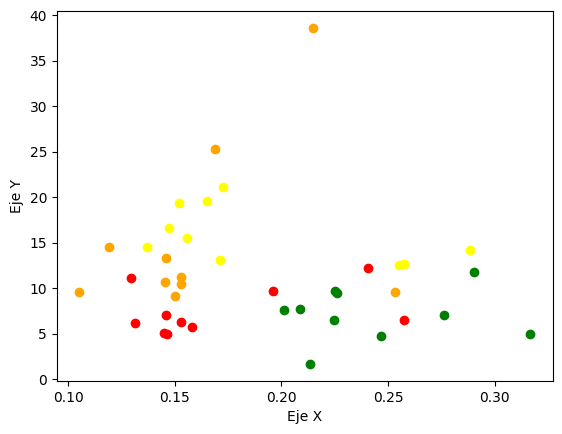

In [ ]:
cutoff = 800
features = dict.fromkeys(fruit_types)

# Extracción de características
for fruit, group in processed.items():
    features[fruit] = None
    for audio in group:
        signal, sr, duration = load_audio(audio)
        audio_rms = np.sqrt(np.mean(signal**2))/np.max(signal) # Es el ratio rms/max

        #spec = librosa.stft(signal, n_fft = FRAME_SIZE, hop_length = HOP_SIZE)
        #BER = band_energy_ratio(spec, split_freq, sr)
        #BER /= np.max(BER)
        #BER = np.mean(BER)

        #centroidal = librosa.feature.spectral_centroid(y=signal, sr=sr, n_fft=FRAME_SIZE, hop_length=HOP_SIZE)[0]
        #centroidal /= np.max(centroidal)
        #centroidal = np.mean(centroidal)
        #smoothed = rms(signal)
        #smoothed = smoothed.reshape(-1,)
        #rms_smoothed = np.mean(smoothed)/np.max(smoothed)
        #filtered = low_pass_filter(signal, sr, cutoff)
        #feat = librosa.feature.zero_crossing_rate(signal, frame_length=FRAME_SIZE, hop_length=HOP_SIZE)[0]
        #max = np.max(zcr)
        #flux = spectral_flux(filtered)
        #max = np.max(flux)
        #flux /= max
        #flux = np.mean(flux)
        #roll_off = librosa.feature.spectral_rolloff(y=signal, sr=sr, n_fft=FRAME_SIZE, hop_length=HOP_SIZE, roll_percent=0.85)[0]
        #max = np.max(roll_off)
        #roll_off /= max
        #roll_off = np.mean(roll_off)
        #smoothed /= np.max(smoothed)
        #N = 1
        #feat = librosa.feature.mfcc(y = signal, sr=sr, n_mfcc = 5, n_fft = FRAME_SIZE, hop_length = HOP_SIZE)
        #feat = librosa.feature.delta(feat, order = 3)

        frames = range(len(feat))
        t = librosa.frames_to_time(frames, sr=sr, n_fft = FRAME_SIZE, hop_length=HOP_SIZE)

        absolute = np.abs(feat)
        #feat /= np.max(absolute)
        #absolute /= np.max(absolute)
        #feat = np.abs(feat)
        #row = feat[N,:]
        #row = np.abs(row)

        momentum = np.dot(t, absolute)
        #momentum/=np.sum(absolute)
        means = np.mean(feat)



        feature = np.array([[audio_rms, momentum]])
        if features[fruit] is not None:
            features[fruit] = np.vstack([features[fruit], feature])
        else:
            features[fruit] = feature
# Ploteo
plot_features2d(features)

El BER no separa nada parece.
Tampoco la media de la rms smoothed o la rms de la rms smoothed
El spectral centroid pareciera que quisiera separar las naranjas de las manzanas pero casi nada. Porbe con el máximo y con la media del ZCR pero no separa. El momentum separa mucho mejor a la pera del resto de las frutas. Los momentos podrías llegar a separar bien capaz si utilizamos otras curvas y no las envolventes
El smoothed aparentemente permite una separación de las manzanas respecto de las demas frutas. El momentum de la primera componente de mel permite la separacón de las peras respecto del resto de las frutas.
La componente 1 de mel permite la separación de peras respecto de manzanas cuando se toma la media.
Me acabo de dar cuenta que el momentum anda joya para separar las peras de las manzanas ccomparado con utilizar solamente la media. Eso tanto para la componente 1 como para la 0. Pero funciona mejor para la 0. Hasta ahora solamente puedo observar la separación de las peras de los demas elementos cuando se utiliza el momentumy nada mas. El RMS pareciera separar medio bien.
El zero croosing rate de la señal sin filtrar permite la separación también de las peras respecto de las manzanas, pero además separa a las bananas de las manzanas (aunque quedan igual muy dispersas). Esto es del ZCR de la señal original sin filtrar y tomando el valor medio del ZCR. Cuando calculamos el momentum, lo que se observa es una separación otra vez entre las manzanas y peras y aparentemente las narnjas también tienden a separarse. Hay que ver que a veces el momentum funciona mejor sin la división por la suma de las componentes del vector ponderado. Por lo menos así, por ejemplo, con el momentum del ZCR se consigue una eseparación de las bananas respecto de lo demas